In [1]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

In [2]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
import scipy.spatial

def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [3]:
#set the root to the Shanghai dataset you download
root = 'D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech'

In [4]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A\\train_data','images')
part_A_test = os.path.join(root,'part_A\\test_data','images')
part_B_train = os.path.join(root,'part_B\\train_data','images')
part_B_test = os.path.join(root,'part_B\\test_data','images')
path_sets = [part_A_train,part_A_test]

In [5]:
path_sets

['D:\\JupyterNotebook\\CSRNet-pytorch-master\\ShanghaiTech\\part_A\\train_data\\images',
 'D:\\JupyterNotebook\\CSRNet-pytorch-master\\ShanghaiTech\\part_A/test_data\\images']

In [6]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [7]:
img_path = img_paths[0]
mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
img= plt.imread(img_path)
k = np.zeros((img.shape[0],img.shape[1]))
gt = mat["image_info"][0,0][0,0][0]
for i in range(0,len(gt)):
    if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
        k[int(gt[i][1]),int(gt[i][0])]=1

In [108]:
img.shape

(768, 1024, 3)

In [109]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Nov 18 20:06:05 2016',
 '__version__': '1.0',
 '__globals__': [],
 'image_info': array([[array([[(array([[ 29.6225116 , 472.92022152],
        [ 54.35533603, 454.96602305],
        [ 51.79045053, 460.46220626],
        ...,
        [597.89732076, 688.27900015],
        [965.77518336, 638.44693908],
        [166.9965574 , 628.1873971 ]]), array([[1546]], dtype=uint16))]],
       dtype=[('location', 'O'), ('number', 'O')])]], dtype=object)}

In [112]:
gt.shape

(1546, 2)

In [8]:
gaussian_filter_density(k)

(768, 1024)
generate density...
done.


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [3.5245415e-05, 3.9891562e-05, 4.5005221e-05, ..., 8.3316003e-08,
        7.9835857e-08, 7.6443328e-08],
       [3.3830602e-05, 3.8291390e-05, 4.3201180e-05, ..., 7.5667948e-08,
        7.2507262e-08, 6.9426157e-08],
       [3.2372249e-05, 3.6641646e-05, 4.1340896e-05, ..., 6.8670069e-08,
        6.5801693e-08, 6.3005523e-08]], dtype=float32)

In [100]:
for img_path in img_paths:
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_1.jpg
(768, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_10.jpg
(683, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_100.jpg
(654, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_101.jpg
(768, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_102.jpg
(768, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_103.jpg
(400, 400)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_104.jpg
(405, 540)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_105.jpg
(632, 990)


generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_157.jpg
(450, 299)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_158.jpg
(671, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_159.jpg
(267, 400)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_16.jpg
(1024, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_160.jpg
(540, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_161.jpg
(480, 640)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_162.jpg
(480, 720)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\ima

done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_214.jpg
(359, 329)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_215.jpg
(298, 446)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_216.jpg
(293, 442)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_217.jpg
(325, 444)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_218.jpg
(411, 443)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_219.jpg
(282, 432)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_22.jpg
(630, 961)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_220.jpg
(377, 10

done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_272.jpg
(478, 359)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_273.jpg
(598, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_274.jpg
(681, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_275.jpg
(270, 360)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_276.jpg
(768, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_277.jpg
(692, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_278.jpg
(620, 620)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_279.jpg
(29

done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_6.jpg
(768, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_60.jpg
(768, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_61.jpg
(683, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_62.jpg
(340, 620)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_63.jpg
(768, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_64.jpg
(768, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_65.jpg
(683, 1024)
generate density...
done.
D:\JupyterNotebook\CSRNet-pytorch-master\ShanghaiTech\part_A\train_data\images\IMG_66.jpg
(768, 1024

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\JupyterNotebook\\CSRNet-pytorch-master\\ShanghaiTech\\part_A/test_data\\ground_truth\\GT_IMG_1.mat'

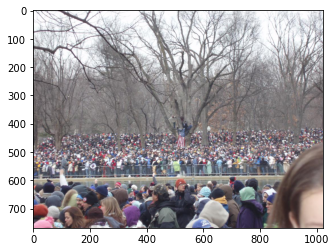

In [101]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[0]))

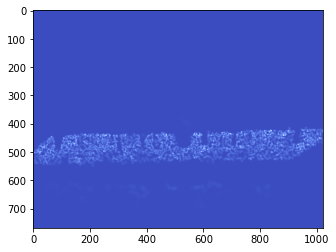

In [113]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.coolwarm)

In [103]:
np.sum(groundtruth)# don't mind this slight variation

1543.841

In [104]:
#now generate the ShanghaiB's ground truth
path_sets = [part_B_train,part_B_test]

In [ ]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [ ]:
for img_path in img_paths:
    print img_path
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k